# Fine Tuning Stable Diffusion

TODO Intro blurb about stable diffusion

Stable Diffusion is great at many things, but not great at everything, and getting results in a particular style or appearance often involves a lot of work "prompt engineering" (TODO links). If you have a particular type of image you'd like to generate, then an alternative to spending a long time crafting an intricate text prompt is to actually fine tune the image generation model itself.

Fine tuning is the common practice of taking a model which has been trained on a wide and diverse dataset, and then training it a bit more on the dataset you are specifically interested in. This is common practice on deep learning and has been shown to be tremendously effective all manner of models from standard image classification networks to GANs (TODO links). In this example fine tune Stable Diffusion on a Pokémon dataset to create a text to image model which makes custom Pokémon based on any text prompt.

TODO examples

## Hardware

TODO

## Data!

First off we need a dataset to train on. Stable Diffusion training needs images each with an accompanying text caption. Things are going to work best if we choose a specific topic and style for our dataset, in this case I'm going to use the Pokémon dataset from FastGAN as it's a decent size (almost a thousand images), high resolution, and has a very consistent style, also who hasn't always wanted to generate their own Pokémon? But there's one problem, it doesn't have any captions for the images!

Instead of painstakingly writing out captions ourselves we're going to use a neural network to do the hardwork for us, specifically BLIP. (But if any Pokémon enthusiasts feel like writing some captions manually please get in touch!). (Todo how to run blip?). The captions aren't perfect, but they're reasonably accurate and good enough for our purposes.

We've uploaded our captioned Pokemon dataset to Huggingface to make it easy to reuse TODO LINK.

In [6]:
from datasets import load_dataset
ds = load_dataset("../../stable-diffusion/datasets/pokemon", split="train")

Resolving data files:   0%|          | 0/835 [00:00<?, ?it/s]

Using custom data configuration pokemon-e58efde541a660cb
Reusing dataset imagefolder (/home/jpinkney/.cache/huggingface/datasets/imagefolder/pokemon-e58efde541a660cb/0.0.0/0fc50c79b681877cc46b23245a6ef5333d036f48db40d53765a68034bc48faff)


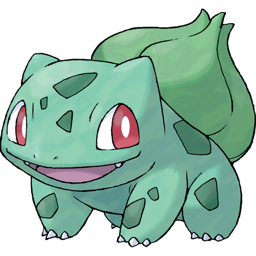

a drawing of a green pokemon with red eyes


In [8]:
sample = ds[0]
display(sample["image"].resize((256, 256)))
print(sample["text"])

## Get ready

Now we have a dataset we need the original model weights which are available for download here: TODO LINK.
Next we need to set up the code and environment for training. We're going to use a fork of the original training code which has been modified to make it a bit more friendly for fine-tuning purposes. TODO LINK TODO move earlier

Stable Diffusion uses yaml based configuration files along with a few extra command line arguments passed to the `main.py` function in order to launch training.

We've created a base yaml configuration file that you can use to edit for fine tuning. The main part you will need to edit is the data configuration:

```yaml
data:
  target: main.DataModuleFromConfig
  params:
    batch_size: 4 # Depends on the available GPU memory
    num_workers: 4
    train:
      target: ldm.data.simple.hf_dataset
      params:
        name: datasets/pokemon
        image_transforms:
        - target: torchvision.transforms.Resize
          params:
            size: 512
            interpolation: 3
        - target: torchvision.transforms.RandomCrop
          params:
            size: 512
        - target: torchvision.transforms.RandomHorizontalFlip
    validation:
      target: ldm.data.simple.TextOnly # Pass arbitrary text samples for evaluation
      params:
        captions:
        - "A pokemon with green eyes, large wings, and a hat"
        - "A cute bunny rabbit"
        - "Yoda"
        - "An epic landscape photo of a mountain"
        output_size: 512
```

## Train!

Once the config file is set up you're ready to train by running the `main.py` script with a few extra arguments:

- `-t` - Do training 
- `--base configs/stable-diffusion/pokemon.yaml` - Use our custom config
- `--gpus 0,1 \` - Use these GPUs
- `--scale_lr False \` - Use the learn rate in the config as is
- `--num_nodes 1 \` - Run on a single machine (possibly with multiple GPUs)
- `--finetune_from models/ldm/stable-diffusion-v1/sd-v1-4-full-ema.ckpt` - Load from the original Stable Diffusion

In [ ]:
%%bash
python main.py \
    -t \
    --base configs/stable-diffusion/pokemon_testing.yaml \
    --gpus 0,1 \
    --scale_lr False \
    --num_nodes 1 \
    --finetune_from models/ldm/stable-diffusion-v1/sd-v1-4-full-ema.ckpt

## Results

During training results should be logged to the the `logs` folder, you should see samples taken every so often (TODO see config)

TODO examples

If we want to use the model we can do so in the normal way, for example using the `txt2img.py` script TODO example, just modifying the checkpoint we pass to be our fine tuned version rather than the original. This model is be compatible with any of the existing repos or user interfaces being developed for Stable Diffusion (TODO eg), and can also be ported to the Huggingface Diffusers library using the following script (TODO)

## Conclusion

Now you know how to train your own Stable Diffusion models on your own datastes. If you train some interesting models please reach out and let us know either in the [Issues](https://github.com/LambdaLabsML/examples/issues) section or on [Twitter](https://twitter.com/LambdaAPI).